In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

#### Code 7.1

In [2]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

#### Code 7.2

In [54]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -77.013: 100%|██████████| 200000/200000 [00:26<00:00, 7505.23it/s]
Finished [100%]: Average ELBO = -77.024
100%|██████████| 1000/1000 [00:03<00:00, 320.95it/s]


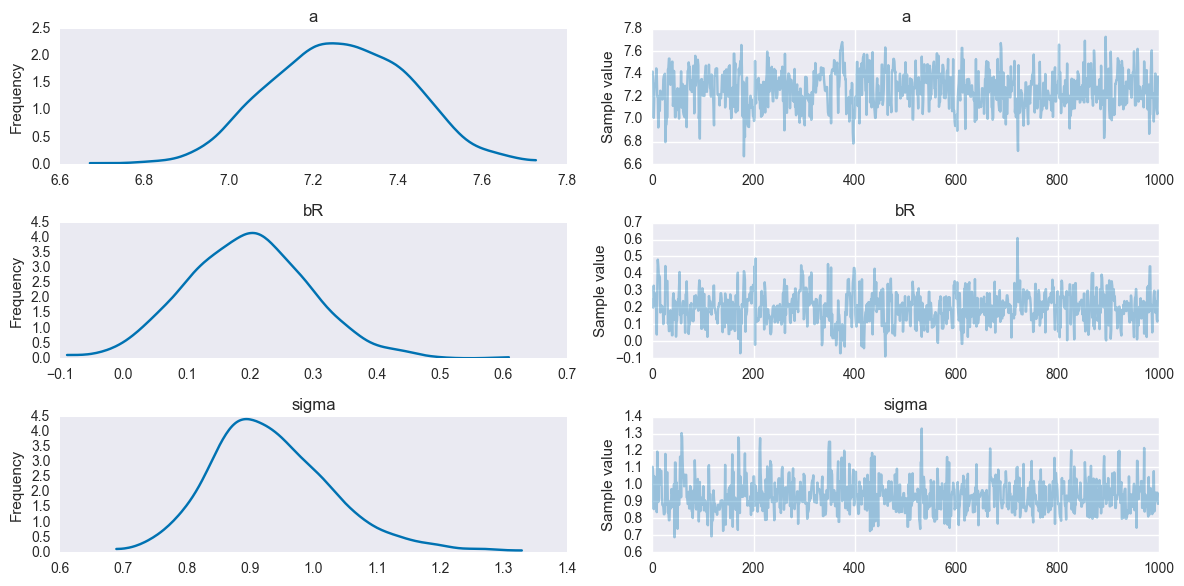

In [55]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [57]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -179.56: 100%|██████████| 200000/200000 [00:25<00:00, 7943.29it/s]
Finished [100%]: Average ELBO = -179.57
100%|██████████| 1000/1000 [00:03<00:00, 297.24it/s]


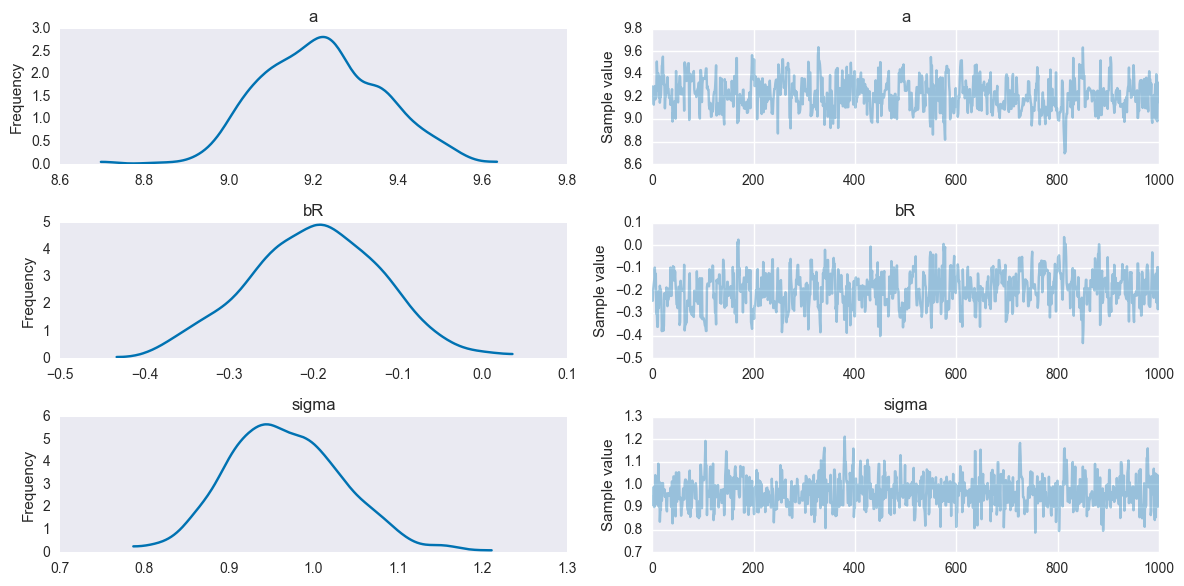

In [58]:
pm.traceplot(trace_7_2_2, varnames);

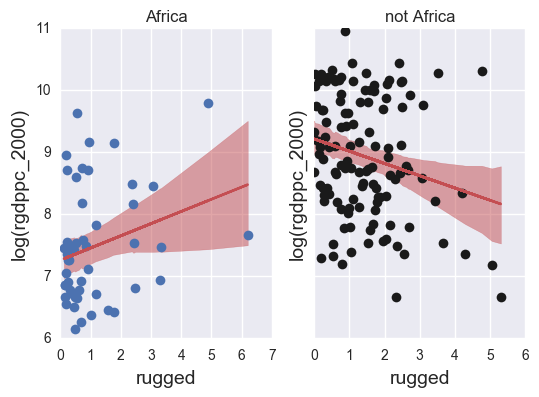

In [103]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'r')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'r')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

#### Code 7.3

In [3]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -281.09: 100%|██████████| 200000/200000 [00:25<00:00, 7814.30it/s]
Finished [100%]: Average ELBO = -281.08
100%|██████████| 1000/1000 [00:03<00:00, 263.30it/s]


#### Code 7.4

In [4]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -251.65: 100%|██████████| 200000/200000 [00:27<00:00, 7144.43it/s]
Finished [100%]: Average ELBO = -251.63
100%|██████████| 1000/1000 [00:04<00:00, 227.89it/s]


#### Code 7.5

In [19]:
def compare_waic(mod1, trace1, mod2, trace2):
    '''Compare fitted models using widely available information criteria.'''
    waic1 = pm.stats.waic(model=mod1, trace=trace1, pointwise=True)
    waic2 = pm.stats.waic(model=mod2, trace=trace2, pointwise=True)
    
    # Calculate diff in expected predictive accuracy
    diff = waic2[2] - waic1[2]
    d_waic = np.sum(diff)
    d_se = np.sqrt(len(diff)) * np.var(diff)
    
    print "     \tWAIC \tpWAIC \tdWAIC \tSE \tdSE"
    print "mod1  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic1[0], waic1[3], np.abs(d_waic), waic1[1], d_se)
    print "mod2  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic2[0], waic2[3], np.abs(d_waic), waic2[1], d_se)

In [20]:
compare_waic(model_7_3, trace_7_3, model_7_4, trace_7_4)

     	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	539.1 	2.4 	62.6 	13.0 	16.5
mod2  	476.5 	4.4 	62.6 	14.8 	16.5


#### Code 7.6

In [107]:
#### Code 7.7

In [108]:
### Code 7.8

In [109]:
#### Code 7.9

In [110]:
#### Code 7.10


In [111]:
#### Code 7.11

In [112]:
### Code 7.12

In [113]:
#### Code 7.13

In [114]:
#### Code 7.14

In [115]:
#### Code 7.15

In [116]:
#### Code 7.16

In [117]:
#### Code 7.17

In [118]:
#### Code 7.19

In [119]:
#### Code 7.20

In [120]:
### Code 7.21